In [42]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans
import folium
import add_geometry_lines as agl
import random
import geopandas as gpd

In [2]:
def traj_features(csv_file, file_name=None):
    '''
    Calculates trajectories features: convex hull volume, displacement, ...

    :param csv_file: path to csv file with object's x, y coords.
    :return: a dataframe with the tracked objects' trajectories' features.
    '''
    # Open input csv and create a new dataframe to store features
    source_df = pd.read_csv(csv_file)

    df = pd.DataFrame()

    # Filter out object which appear for less than 2 sec (given 20 f/s)
    df['object_id'] = source_df['object_id'].unique()
    grouped_data = source_df.groupby('object_id').filter(lambda group: len(group) >= 40)

    for i, group in grouped_data.groupby('object_id'):
        # Calculate convex hull volume
        traj_points = list(zip(group['x'], group['y']))
        convex = ConvexHull(traj_points)
        df.loc[df['object_id'] == i, 'convex_hull_volume'] = convex.volume

        df.loc[df['object_id'] == i, 'max_speed'] = group['speed_kmh'].max()

        # Calculate displacement
        displ = np.sqrt((traj_points[-1][0] - traj_points[0][0])**2 + (traj_points[-1][1] - traj_points[0][1])**2)
        df.loc[df['object_id'] == i, 'displacement'] = displ

        # Calculate total distance
        group['delta_dist'] = np.sqrt(group['x'].diff()**2 + group['y'].diff()**2)
        df.loc[df['object_id'] == i, 'total_distance'] = group['delta_dist'].sum()

        df.loc[df['object_id'] == i, 'start-x'] = round(traj_points[0][0])
        df.loc[df['object_id'] == i, 'start-y'] = round(traj_points[0][1])
        df.loc[df['object_id'] == i, 'end-x'] = round(traj_points[-1][0])
        df.loc[df['object_id'] == i, 'end-y'] = round(traj_points[-1][1])
    df.fillna({'convex_hull_volume': 0, 'displacement': 0, 'max_speed': 0}, inplace=True)  # Change NaN values to 0 if any
    df['ratio'] = df['displacement'] / df['total_distance']
    if file_name is not None:
        df.to_csv(file_name, encoding='utf-8', index=False)
    
    df.set_index('object_id', inplace=True)  # Set 'object_id' as the index
    
    return df


In [3]:
features = traj_features("C:/Users/anape/Downloads/outsight/resources/0109-traj.csv")

In [32]:
def kmeans_clustering(features, num_clusters):
    """
    Perform K-Means clustering on a DataFrame.

    :param dataframe: input df with features.
    :param num_clusters: number of clusters to create.
    :return: dataframe with an additional 'cluster' column.
    """
    
    features1 = features.copy(deep=True).fillna(0)
    
    kmeans = KMeans(n_clusters=num_clusters)

    # Fit the model to the data
    kmeans.fit(features1)

    # Get cluster labels for each data point
    cluster_labels = kmeans.labels_

    # Add the cluster labels to the DataFrame
    features1['cluster'] = cluster_labels
    

    return features1


In [20]:
# Importing the data
import folium
import pyproj
import random
from shapely import LineString

df = pd.read_csv("C:/Users/anape/Downloads/outsight/resources/0109-traj.csv")

# Drop unnecessary columns
df.drop('zones',axis=1, inplace=True)
df.drop('z',axis=1, inplace=True)
df.drop('volume_m3',axis=1, inplace=True)

In [56]:
cluster_df = kmeans_clustering(features,15)

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# Transforming
# Create a geodataframe with LineStrings from the original full data
gdf = agl.add_geometry(df)

source_crs_wkt = 'DERIVEDPROJCRS["",BASEPROJCRS["WGS 84 / Pseudo-Mercator",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["Popular Visualisation Pseudo-Mercator",METHOD["Popular Visualisation Pseudo Mercator",ID["EPSG",1024]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]]],DERIVINGCONVERSION["Affine",METHOD["Affine parametric transformation",ID["EPSG",9624]],PARAMETER["A0",-3716438.1093590977,LENGTHUNIT["metre",1],ID["EPSG",8623]],PARAMETER["A1",0.6158540384148486,SCALEUNIT["coefficient",1],ID["EPSG",8624]],PARAMETER["A2",0.40263073503547436,SCALEUNIT["coefficient",1],ID["EPSG",8625]],PARAMETER["B0",-2194507.2465994842,LENGTHUNIT["metre",1],ID["EPSG",8639]],PARAMETER["B1",-0.40263073503547436,SCALEUNIT["coefficient",1],ID["EPSG",8640]],PARAMETER["B2",0.6158540384148486,SCALEUNIT["coefficient",1],ID["EPSG",8641]]],CS[Cartesian,2],AXIS["easting (X)",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["northing (Y)",north,ORDER[2],LENGTHUNIT["metre",1]]]'
target_crs_wkt = 'EPSG:3857' 

transformer = pyproj.Transformer.from_crs(source_crs_wkt, target_crs_wkt, always_xy=True)

# Assuming you have an existing GeoDataFrame called 'original_gdf' with LineString geometries
# Make a copy of the original GeoDataFrame to preserve the original data
transformed_gdf = gdf.copy()

# Define a function to apply the transformation to each geometry
def transform_geometry(geometry):
    # Use the transformer to perform the coordinate transformation
    transformed_coords = transformer.transform(geometry.xy[0], geometry.xy[1])
    
    # Create a new LineString with the transformed coordinates
    return LineString(zip(*transformed_coords))

# Apply the transformation to the 'geometry' column of the GeoDataFrame
transformed_gdf['geometry'] = gdf['geometry'].apply(transform_geometry)

In [57]:
merged_df = pd.merge(cluster_df, transformed_gdf, on='object_id', how='inner')

In [58]:
merged_gdf = gpd.GeoDataFrame(merged_df, geometry=merged_df['geometry'])

In [59]:
def plot_interactive(gdf, n):
    # create a folium map
    map_clusters = folium.Map(location=[42.659395820532694, 23.3165594735582], zoom_start=50)

    # basemap layer
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri',
        name='Esri Satellite',
        overlay=False,
        control=True
    ).add_to(map_clusters)

    grouped_clusters = gdf.groupby('cluster')

    # Define a custom color palette for your 15 clusters
    color_palette = []
    for _ in range(n):
        color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        color_palette.append(color)

    # Loop through the groups and add them as separate GeoJson layers with custom colors
    for i, (cluster, data) in enumerate(grouped_clusters):
        # Assign a custom color from the palette or use random color if more clusters than colors
        color = color_palette[i % len(color_palette)]
        
        geojson = folium.GeoJson(data, name=f'Cluster {cluster}', style_function=lambda x, color=color: {'color': color})
        geojson.add_to(map_clusters)

    # add a LayerControl to the map
    folium.LayerControl().add_to(map_clusters)

    return map_clusters


In [73]:
m = plot_interactive(merged_gdf,15)

In [76]:
m.save('0109_kmeans_cluster_map.html')

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


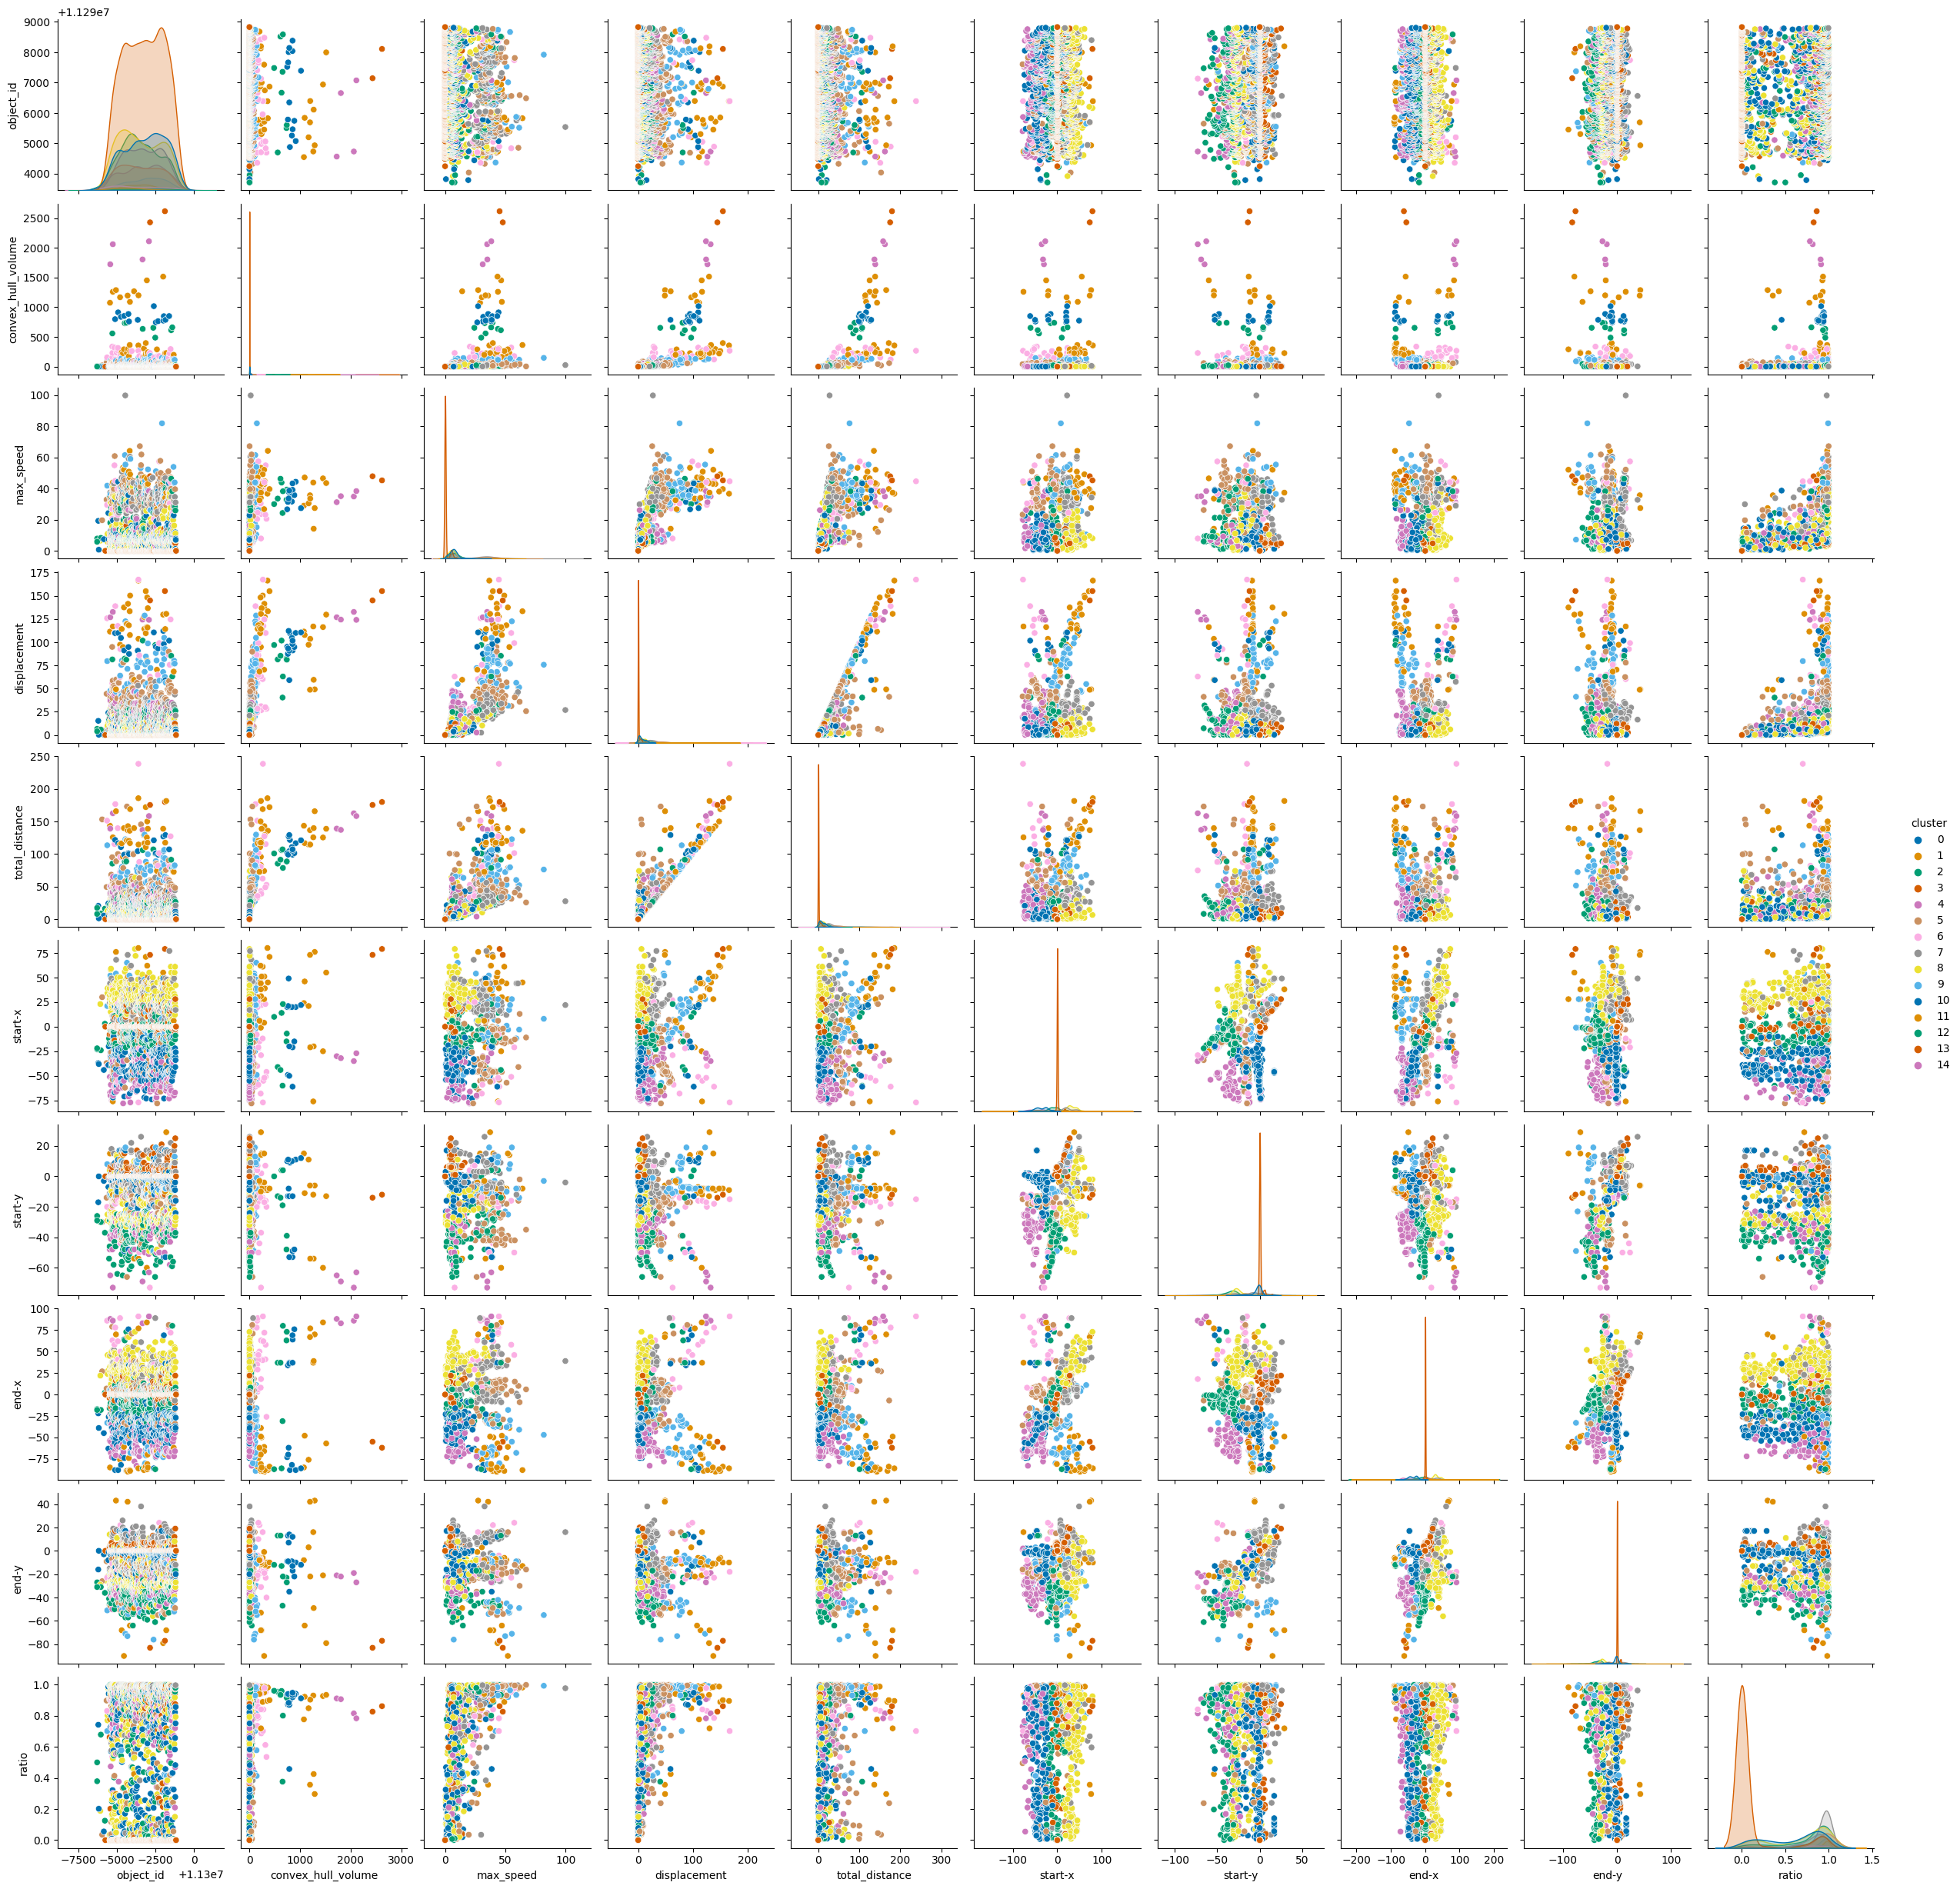

In [82]:
import seaborn as sns
sns.pairplot(merged_df, hue='cluster', palette='colorblind')

In [80]:
merged_df.cluster.unique()

array([ 0,  8, 12,  9,  7,  5,  1,  3, 14,  6,  4,  2, 10, 11, 13])

In [93]:
perfect_features = traj_features("C:/Users/anape/Downloads/outsight/resources/0109-perfect-traj.csv")
cluster_perfect_df = kmeans_clustering(perfect_features,12)
merged_perfect_df = pd.merge(cluster_perfect_df, transformed_gdf, on='object_id', how='inner')
merged_perfect_df = gpd.GeoDataFrame(merged_perfect_df, geometry=merged_perfect_df['geometry'])
m = plot_interactive(merged_perfect_df,12)

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [95]:
m.save('0109_perfect_kmeans_cluster_map.html')

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


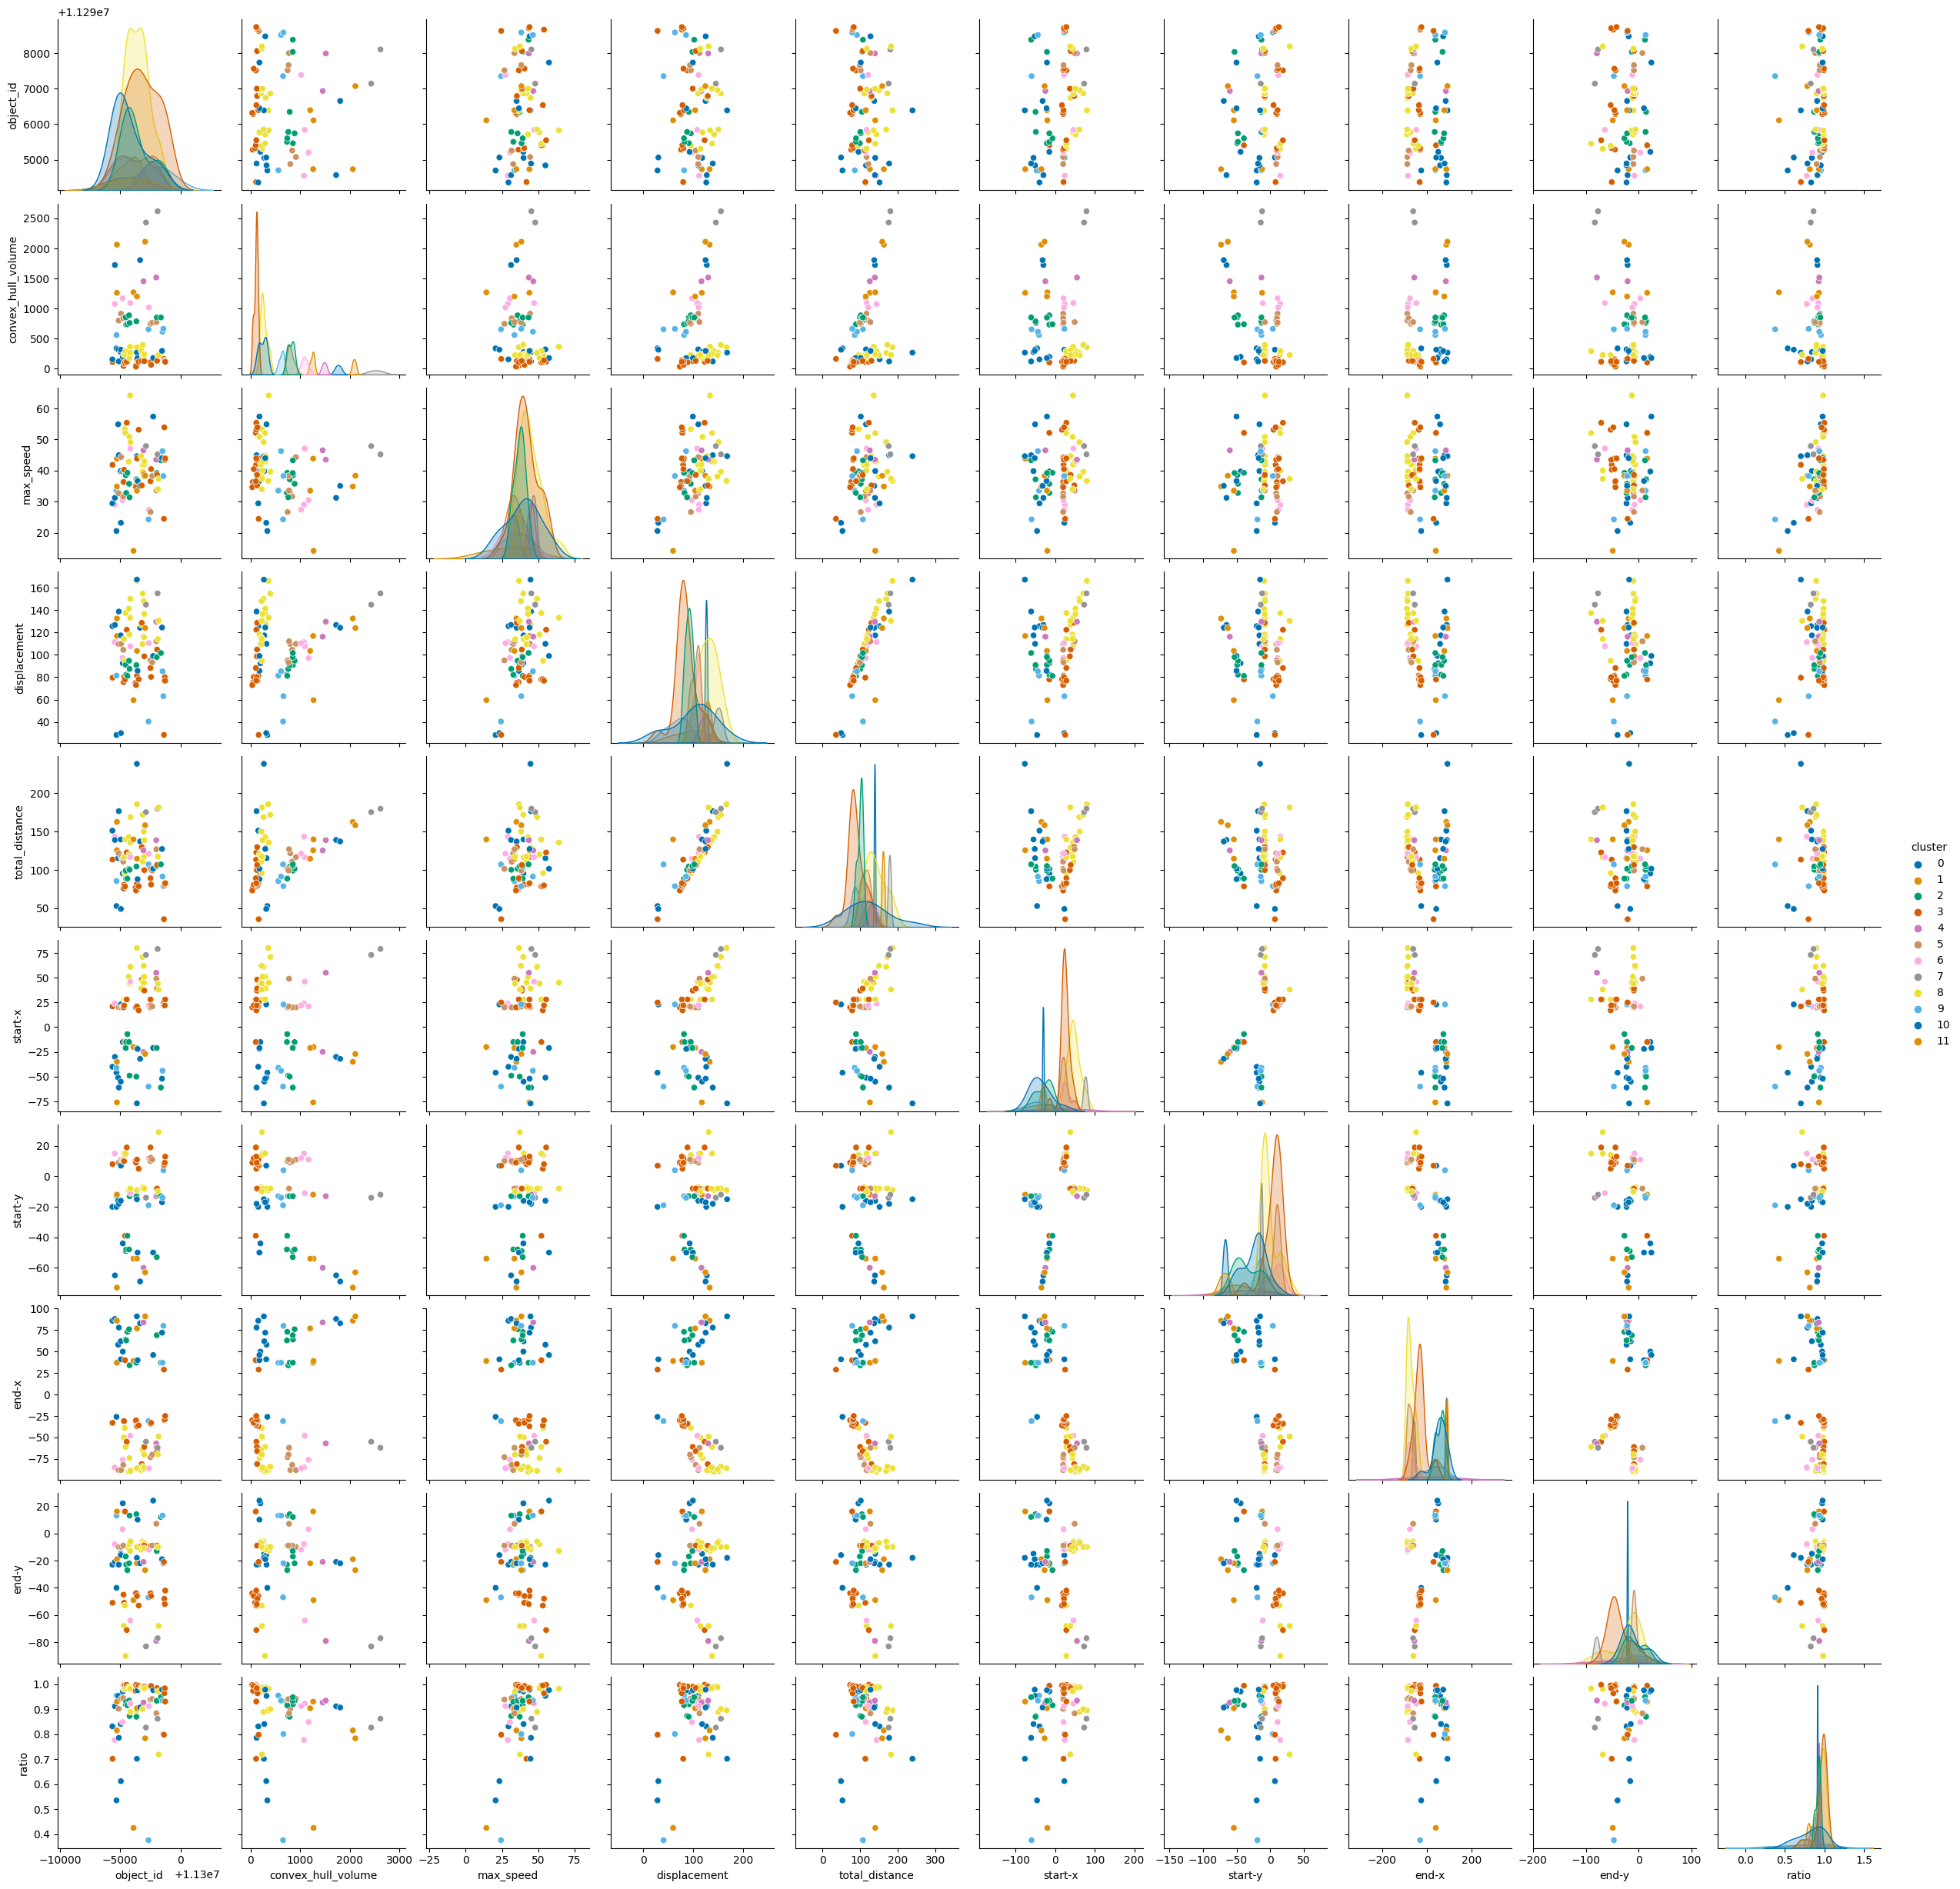

In [96]:
sns.pairplot(merged_perfect_df, hue='cluster', palette='colorblind')

In [97]:
perfect_features

convex_hull_volume  max_speed  displacement  total_distance  \
object_id                                                                
11294369           110.807215      41.86     79.600861      113.410503   
11294548          1075.656943      29.01    111.407268      143.355981   
11294359           154.570060      29.45    125.699381      151.161412   
11294565          1723.456154      31.23    126.798499      139.035812   
11294696           337.294668      20.57     28.257568       52.763126   
...                       ...        ...           ...             ...   
11298586           661.399836      38.25     63.032719       78.680260   
11298631           161.957225      24.46     28.409852       35.597491   
11298666           138.589942      53.91     76.839622       79.699498   
11298706           123.864345      43.47     79.999683       81.298886   
11298739           113.756816      43.92     76.935709       82.622787   

           start-x  start-y  end-x  end-y     ratio  
object_id                                            
11294369      21.0      8.0  -33.0  -51.0  0.701883  
11294548      24.0     15.0  -85.0   -8.0  0.777137  
11294359     -40.0    -20.0   86.0  -23.0  0.831557  
11294565     -30.0    -65.0   88.0  -21.0  0.911984  
11294696     -46.0    -20.0  -26.0  -40.0  0.535555  
...            ...      ...    ...    ...       ...  
11298586      23.0      4.0   80.0  -22.0  0.801125  
11298631      25.0      7.0   29.0  -21.0  0.798086  
11298666      22.0      8.0  -30.0  -48.0  0.964117  
11298706      22.0      9.0  -29.0  -52.0  0.984019  
11298739      28.0     13.0  -25.0  -42.0  0.931168  

[78 rows x 9 columns]